In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import Button, IntSlider, interactive_output, HBox, Output, Box
from ipywidgets import interact, interactive, fixed, interact_manual
from amplify import Solver, decode_solution, gen_symbols, BinaryPoly, sum_poly, BinaryQuadraticModel
from amplify.client import FixstarsClient
from amplify.constraint import equal_to, penalty
from PIL import Image

In [2]:
W = 384
H = 288
# ベンチマーク画像
imgL = Image.open('img/tsukuba/scene1.row3.col1.ppm')
imgR = Image.open('img/tsukuba/scene1.row3.col3.ppm')
imgD = Image.open('img/tsukuba/truedisp.row3.col3.pgm')

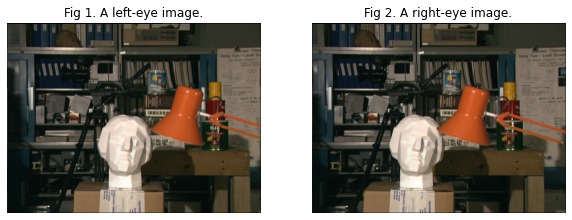

In [24]:
# 入力画像を表示
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(imgL)
plt.title('Fig 1. A left-eye image.')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(imgR)
plt.title('Fig 2. A right-eye image.')
plt.axis('off')
plt.show()

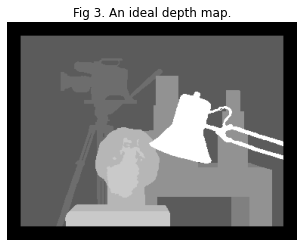

In [25]:
# 理想の視差マップを表示
plt.imshow(imgD, cmap='gray')
plt.title('Fig 3. An ideal depth map.')
plt.axis('off')
plt.show()

In [26]:
# 自由視点映像のインタフェースを表示
def callback(x):
    W, H = imgL.size
    img = np.zeros((H, W, 3), dtype=int)
    img[:,:,:] = (0,255,0)
    depth = np.zeros((H, W), dtype=int)
    try:
        plt.title('x = ' + str(x) , fontsize=20)
        for i in range(H):
            for j in range(W):
                _depth = imgD.getpixel((j,i))
                _x = int(j+(_depth-90)*x/30)
                _x = min(W-1, _x)
                if depth[i,_x] >= _depth:
                    continue
                img[i,_x,:] = imgR.getpixel((j,i))
                depth[i,_x] = _depth
        plt.imshow(img)
    except:
        pass
    plt.show()
interact(callback, x=(-12,12,3));

interactive(children=(IntSlider(value=0, description='x', max=12, min=-12, step=3), Output()), _dom_classes=('…

In [27]:
# 以降定式化
# ただし，有意な視差マップは得られなかった
from amplify import BinaryPoly, BinaryQuadraticModel, gen_symbols, Solver, sum_poly, pair_sum, decode_solution
a = np.zeros((H//3, W//3), dtype=int)
K = 5
q = gen_symbols(BinaryPoly, H//3, W//3, K)
HH = H//3
WW = W//3
def dist(i, j, k):
    distance = 0
    th = 128
    for dx in [-1, 0, +1]:
        if j+dx < 0 or j+dx >= WW or j-k+dx <0: continue
        for dy in [-1, 0, +1]:
            if i+dy < 0 or i+dy >= HH: continue            
            r, g, b = imgL.getpixel((i,j))
            rr, gg, bb = imgR.getpixel((i, 0 if j-k<0 else j-k))
            if (r > th and rr > th) or (r <= th and rr <= th): distance +=1
            if (g > th and gg > th) or (g <= th and gg <= th): distance +=1
            if (b > th and bb > th) or (b <= th and bb <= th): distance +=1
    return distance

In [17]:
# 制約
H0 = sum([equal_to(sum_poly([q[i][j][k] for k in range(K)]), 1) for i in range(HH) for j in range(WW)]) * 1  # 重み調節

In [18]:
# コスト関数
H1 = sum_poly(HH, lambda i: sum_poly(WW, lambda j: sum_poly(K, lambda k:dist(i,j,k)*q[i][j][k]))) * 1  # 重み調節

In [19]:
model = BinaryQuadraticModel(H1, H0)

In [20]:
# 実行
client = FixstarsClient()
client.token = "ここにトークンを入力してください"
client.parameters.timeout = 100
solver = Solver(client)
solver.filter_solution = False
result = solver.solve(model)
x = decode_solution(q, result[0].values)

In [22]:
# 結果を画像に変換
D = np.zeros((HH,WW), dtype=int)
for i in range(HH):
    for j in range(WW):
        for k in range(K):
            if x[i][j][k] == 1:
                D[i,j] = k

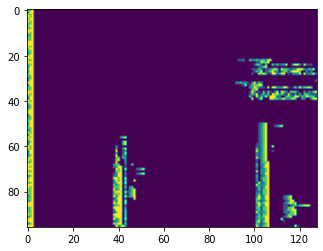

In [23]:
# 視差マップ
plt.imshow(D)
plt.show()